<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы." data-toc-modified-id="Выводы.-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы.</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install phik -q

!pip install scikit-learn==1.1.3 -q

!pip install catboost -q

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

import seaborn as sns
from matplotlib import pyplot as plt


from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import TimeSeriesSplit

from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)


import lightgbm as lgb

from sklearn.linear_model import(
    Ridge,
    LinearRegression,
    LogisticRegression
)

from catboost import CatBoostRegressor


from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    roc_curve,
    roc_auc_score,
    f1_score,
    make_scorer
)

    
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)




RANDOM_STATE = 42
TEST_SIZE = 0.1

Загрузим данные.

In [3]:
try:
    taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
def data_info(data):
    pd.set_option('display.max_columns', None)
    display(data.head())
    display(data.describe(include='all'))
    data.info()

In [5]:
data_info(taxi)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В данных содержится 26496 строк. В столбце num_orders содержится количество вызовов такси за период с марта  по август 2018 года. Количество вызовов дается через каждые 10 минут. Количество заказов варьируется от нуля до 119. В среднем делается 14 заказов.

In [6]:
taxi.sort_index(inplace=True)

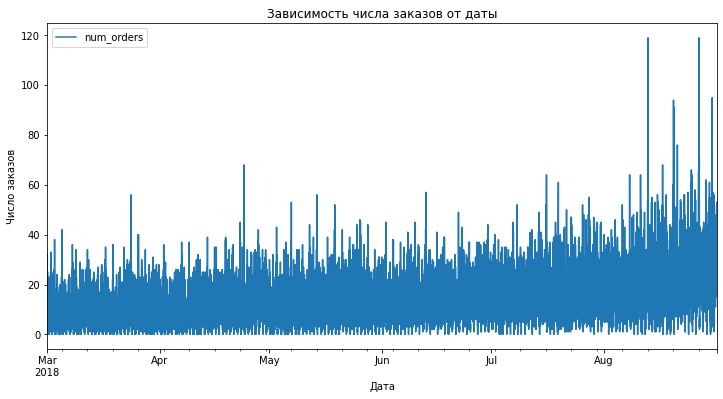

In [7]:
taxi.plot(figsize=(12,6))
plt.ylabel('Число заказов')
plt.xlabel('Дата')
plt.title('Зависимость числа заказов от даты')
plt.legend() 
plt.show();

Проведем ресемплирование данных по одному часу.

In [8]:
taxi = taxi.resample('1H').sum()

Проверим, в хронологическом ли порядке расположены даты и время.

In [9]:
print(taxi.index.is_monotonic)

True


Даты и время расположены в хронологическом порядке.

## Анализ

Проведем анализ имеющихся данных.

In [10]:
taxi_0 = taxi.copy()

In [11]:
taxi_0['mean'] = taxi_0['num_orders'].rolling(72).mean()
taxi_0['std'] = taxi_0['num_orders'].rolling(72).std()

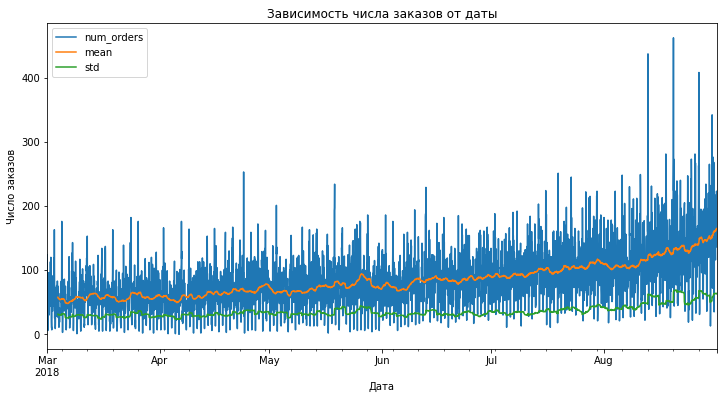

In [12]:
taxi_0.plot(figsize=(12,6))
plt.ylabel('Число заказов')
plt.xlabel('Дата')
plt.title('Зависимость числа заказов от даты')
plt.legend() 
plt.show();

Из графика видно, что в пределах месяца количество заказов колеблется, на первый взгляд хаотично. Но при этом наблюдается общий тренд - монотонное увеличение числа заказов с марта по август. Скользящее среднее за трое суток растет, то есть, ряд не является стационарным. Стандартное отклонение - почти постоянно. 

In [13]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Разложим временной ряд на тренд и сезонную компоненту.

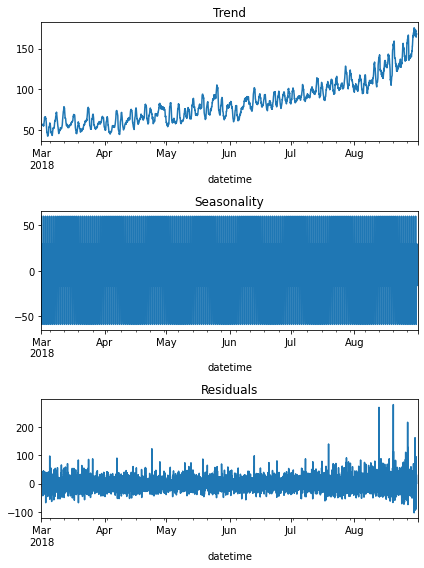

In [14]:
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Как уже было замечено ранее, наблюдается общий тренд - монотонное увеличение числа заказов с марта по август. К сожалению, у нас нет данных за осенние и зимние месяцы. С учетом других месяцев тренд мог бы поменяться.
Что происходит с сезонностью, неясно. Посмотрим на неё более подробно на более коротких промежутках времени.

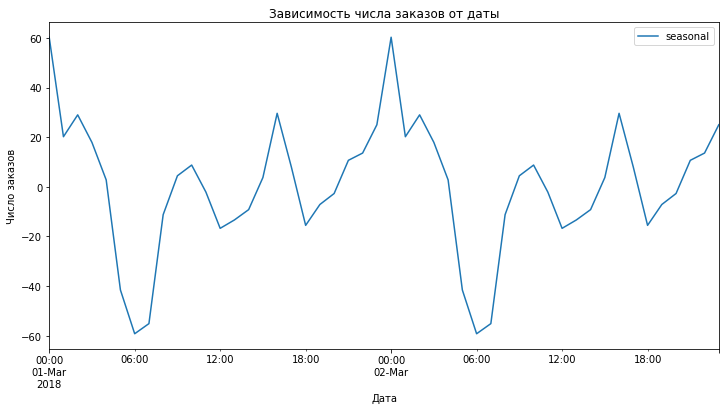

In [15]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca(), figsize=(12,6))
plt.ylabel('Число заказов')
plt.xlabel('Дата')
plt.title('Зависимость числа заказов от даты')
plt.legend() 
plt.show();

Из графика видно, что наблюдается сезонность. Каждый день, в определенные часы наблюдаются увеличения и уменьшения числа заказов. Как-то немного нелогично, что самое большое число заказов наблюдается в вечернее  и ночное время. В районе 6 утра наблюдается резкое снижение заказов.

In [17]:
taxi_d = taxi.resample('1D').sum()

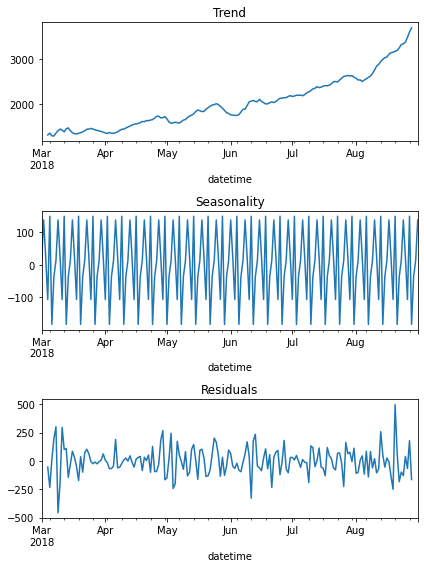

In [18]:
decomposed_d = seasonal_decompose(taxi_d)

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed_d.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_d.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_d.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

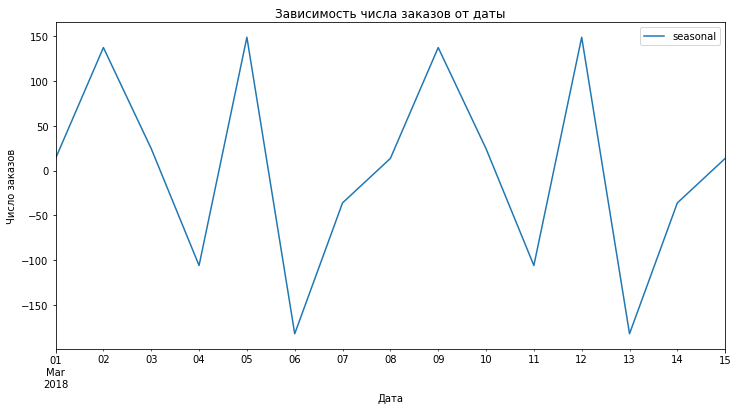

In [19]:
decomposed_d.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca(), figsize=(12,6))
plt.ylabel('Число заказов')
plt.xlabel('Дата')
plt.title('Зависимость числа заказов от даты')
plt.legend() 
plt.show();

Создадим признаки для горизонта прогнозирования в один шаг. Напишем функцию для создания признаков.

Добавим отстающие на 1 час значения (lag_1-24), скользящее среднее (rolling_mean), а также день недели.

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [21]:
make_features(taxi, 24, 24)
display(taxi.head())

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Обучение

Разделим данные на обучающую и тестовую выборки. Отстающие значения и скользящее среднее вычисляются по прошлым данным. Признаки для первых значений тестовой выборки находятся в конце обучающей выборки.

Получить признаки для первых значений обучающей выборки нельзя: исторических данных по ним нет. В предыдущих задачах значения этих признаков были NaN. Их нужно удалить.

In [23]:
train, test = train_test_split(taxi, shuffle=False, test_size=TEST_SIZE)

In [24]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [25]:
train = train.dropna()

In [26]:
print(train.shape)
print(test.shape)

(3950, 28)
(442, 28)


В выборке выделим признаки и целевой признак.

In [27]:
X_train = train.drop(columns='num_orders')
y_train = train['num_orders']
X_test = test.drop(columns='num_orders')
y_test = test['num_orders']

In [28]:
num_col = ['rolling_mean', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24']
cat_col = ['dayofweek', 'hour']

In [29]:
# создаём пайплайн для подготовки признаков из списка cat_col: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)

In [30]:
num_pipe = Pipeline(
    [
        (
            'simpleImputer_num', 
            SimpleImputer(missing_values=np.nan, strategy='median')
        ),
        (
            'num', 
            StandardScaler()
        )
    ]
)

In [31]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_col),
        ('num', num_pipe, num_col)
    ], 
    remainder='passthrough',
    
)

In [32]:
# создаём итоговый пайплайн: подготовка данных и модель
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6))
    ]
)

param_grid = [
    # словарь для модели CatBoostClassifier()
    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE)],
        'models__depth': range(3, 8),
        'models__iterations': range(800, 1000),
        'models__learning_rate': np.arange(0.01, 0.1),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
     # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsRegressor() 
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
   
    
    ]

In [33]:
tscv = TimeSeriesSplit(n_splits=5)

In [34]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=tscv, 
    scoring='neg_mean_squared_error',
    error_score='raise',
    n_jobs=-1
)

In [35]:
randomized_search.fit(X_train, y_train)

0:	learn: 29.5541438	total: 52.4ms	remaining: 48s
1:	learn: 29.4135471	total: 56.5ms	remaining: 25.9s
2:	learn: 29.2876455	total: 60.1ms	remaining: 18.3s
3:	learn: 29.1574522	total: 63.7ms	remaining: 14.6s
4:	learn: 29.0478257	total: 67.3ms	remaining: 12.3s
5:	learn: 28.9173638	total: 70.6ms	remaining: 10.7s
6:	learn: 28.7958999	total: 74ms	remaining: 9.63s
7:	learn: 28.6902759	total: 77.6ms	remaining: 8.82s
8:	learn: 28.5722419	total: 81.2ms	remaining: 8.2s
9:	learn: 28.4431316	total: 85.1ms	remaining: 7.73s
10:	learn: 28.3303200	total: 88.9ms	remaining: 7.33s
11:	learn: 28.2110516	total: 92.5ms	remaining: 6.99s
12:	learn: 28.0890128	total: 96.1ms	remaining: 6.69s
13:	learn: 27.9911132	total: 100ms	remaining: 6.45s
14:	learn: 27.8830945	total: 104ms	remaining: 6.25s
15:	learn: 27.7716390	total: 108ms	remaining: 6.08s
16:	learn: 27.6542994	total: 112ms	remaining: 5.91s
17:	learn: 27.5347868	total: 115ms	remaining: 5.76s
18:	learn: 27.4303193	total: 119ms	remaining: 5.61s
19:	learn: 27.

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore...
                                         'models__learning_rate': array([0.01]),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [KNeighborsRegressor()],
                                         'models__n_neighbors': range(2, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   scoring='neg_mean_squared_error')

In [36]:
# выведите параметры лучшей модели
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dayofweek', 'hour']),
                                                 ('num', StandardScaler(),
                                                  ['rolling_mean', 'lag_1',
                      

In [37]:
print(randomized_search.best_params_)

{'preprocessor__num': StandardScaler(), 'models__learning_rate': 0.01, 'models__iterations': 923, 'models__depth': 7, 'models': <catboost.core.CatBoostRegressor object at 0x7fe5008bba60>}


In [38]:
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Метрика лучшей модели на кросс-валидации: -641.0248681789633


In [39]:
print ('RMSE лучшей модели на кросс-валидации:', (-1*randomized_search.best_score_)**(0.5))

RMSE лучшей модели на кросс-валидации: 25.318468914588088


In [40]:
best_model = randomized_search.best_estimator_

## Тестирование

In [41]:
y_pred = best_model.predict(X_test)

Проверим значение метрики RMSE на треннировочной и тестовой выборках для всех трех моделей.

In [42]:
print("RMSE обучающей выборки:",(mean_squared_error(y_train, best_model.predict(X_train)))**(0.5))
print("RMSE тестовой выборки:", (mean_squared_error(y_test,y_pred))**(0.5))

RMSE обучающей выборки: 19.59499377042189
RMSE тестовой выборки: 43.278355829336455


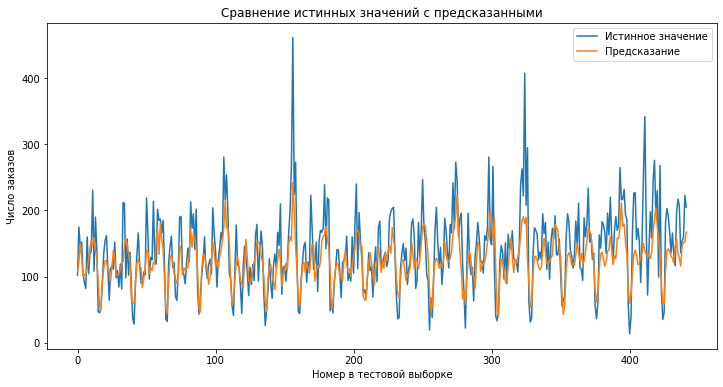

In [43]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Истинное значение')
plt.plot(y_pred, label='Предсказание')
plt.ylabel('Число заказов')
plt.xlabel('Номер в тестовой выборке')
plt.title('Сравнение истинных значений с предсказанными')
plt.legend()
plt.show();

Лучшая модель удовлетворяет условиям задания: значение метрики RMSE на тестовой выборке должно быть не больше 48. Лучшие значения метрики RMSE на обучающей и тестовой выборках достигаются при использовании модели CatBoostRegressor('preprocessor__num': StandardScaler(), 'models__learning_rate': 0.01, 'models__iterations': 923, 'models__depth': 7, 'models': CatBoostRegressor). Значение RMSE на тестовой выборке получилось равным 43.

## Выводы.

В данных содержится 26496 строк. В столбце num_orders содержится количество вызовов такси за период с марта  по август 2018 года. Количество вызовов дается через каждые 10 минут. Количество заказов варьируется от нуля до 119. В среднем делается 14 заказов.

Проведено ресемплирование данных по одному часу. Даты и время расположены в хронологическом порядке.

В пределах месяца количество заказов колеблется, на первый взгляд, хаотично. Но при этом наблюдается общий тренд - монотонное увеличение числа заказов с марта по август. Скользящее среднее за трое суток растет, то есть, ряд не является стационарным. Стандартное отклонение - почти постоянно.

Разложение временного рядя на тренд и сезонную компоненту показало следующее:
Как уже было замечено ранее, наблюдается общий тренд - монотонное увеличение числа заказов с марта по август. К сожалению, у нас нет данных за осенние и зимние месяцы. С учетом других месяцев тренд мог бы поменяться.
Наблюдается сезонность. Каждый день, в определенные часы наблюдаются увеличения и уменьшения числа заказов. Как-то немного нелогично, что самое большое число заказов наблюдается в вечернее  и ночное время. В районе 6 утра наблюдается резкое снижение заказов. Помимо суточной, наблюдается и недельная сезонность. Максимумы заказов приходятся на вторник и пятницу, минимум - на субботу.

Созданы признаки для горизонта прогнозирования в один шаг. Добавлены отстающие на 1 час значения (lag_1-24), скользящее среднее (rolling_mean), а также день недели.

Для предсказания целевого признака - числа заказов выбрали лучшую модель из трех: LinearRegressor, CatBoostRegressor и KNeighborsRegressor.  Для подбора гиперпараметров моделей использовали рандомизированный (случайный) поиск гиперпараметров с помощью RandomizedSearchCV, который является более быстродействующим по сравнению с GridSearchCV.

Параметры лучшей модели: 'preprocessor__num': StandardScaler(), 'models__learning_rate': 0.01, 'models__iterations': 923, 'models__depth': 7, 'models': CatBoostRegressor.
Значение RMSE на тестовой выборке получилось равным 43.


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48